# Rover

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline

import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick look at the data

### Collection
Run the simulator in "Training Mode" and record some data.

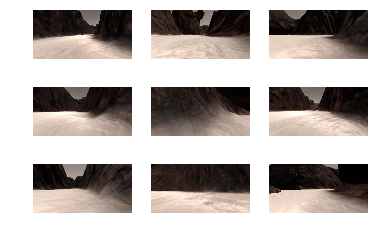

In [3]:
path = '../IMG/*'
img_list = glob.glob(path)
# Grab few random images and display it
for i in range(1, 10):
    idx = np.random.randint(0, len(img_list)-1)
    image = mpimg.imread(img_list[idx])
    plt.subplot(3, 3, i)
    plt.imshow(image)
    plt.axis('off')

### Calibration
Read in and display example grid and rock sample calibration images.  Use the grid for perspective transform and the rock image for creating color selection that identifies these samples of interest. 

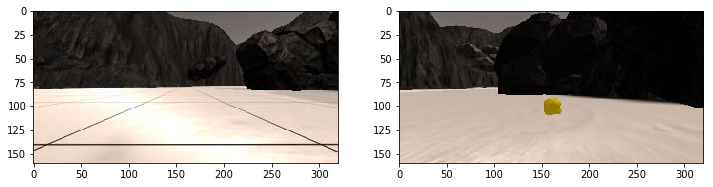

In [4]:
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

### Load and explore rover logs

In [5]:
# Import pandas and read in csv file as a dataframe
import pandas as pd

robot_log = pd.read_csv('../robot_log.csv')
robot_log.head()

,Path,SteerAngle,Throttle,Brake,Speed,X_Position,Y_Position,Pitch,Yaw,Roll
0,/Users/luli/Desktop/Robotics/RoboND-Rover-Proj...,0.0,0.0,1.0,0.0,99.66999,85.58897,0.000235,56.82555,7.740255e-07
1,/Users/luli/Desktop/Robotics/RoboND-Rover-Proj...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000235,56.82555,7.740255e-07
2,/Users/luli/Desktop/Robotics/RoboND-Rover-Proj...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000235,56.82555,7.740255e-07
3,/Users/luli/Desktop/Robotics/RoboND-Rover-Proj...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000235,56.82555,7.740255e-07
4,/Users/luli/Desktop/Robotics/RoboND-Rover-Proj...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000235,56.82555,7.228858e-07


In [6]:
# Summaries
print("Number of examples =", len(robot_log))
print("Average steering angles =", np.mean(robot_log['SteerAngle']))
print("Average throttle =", np.mean(robot_log['Throttle']))
print("Average brake =", np.mean(robot_log['Brake']))
print("Average speed =", np.mean(robot_log['Speed']))
print("Average pitch =", np.mean(robot_log['Pitch']))
print("Average yaw =", np.mean(robot_log['Yaw']))
print("Average roll =", np.mean(robot_log['Roll']))

Number of examples = 25462
Average steering angles = 0.260380830098
Average throttle = 0.0993611430696
Average brake = 0.0456758897964
Average speed = 0.639068834241
Average pitch = 198.387466718
Average yaw = 168.132484076
Average roll = 112.724103404


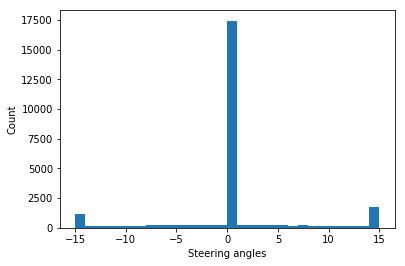

In [7]:
# Plot the distribution of steering angles
plt.hist(robot_log['SteerAngle'], bins=30)
plt.xlabel('Steering angles')
plt.ylabel('Count')

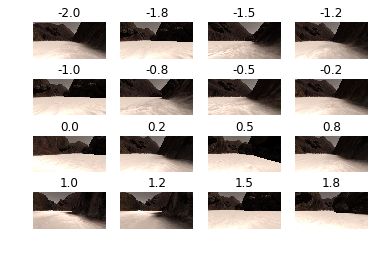

In [8]:
# Look at 16 images for steering angle [-2, 2]
for i in range(16):
    steer = round(-2+i/4, 1)
    for n in range(len(robot_log['SteerAngle'])):
        if round(robot_log['SteerAngle'][n], 1) == steer:
            plt.subplot(4, 4, i+1)
            img = cv2.imread(robot_log["Path"][n])
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(steer)
            break

## Perspective transform

In [ ]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image   
    return warped

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped_grid = perspect_transform(grid_img, source, destination)
warped_rock = perspect_transform(rock_img, source, destination)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped_grid)
plt.subplot(122)
plt.imshow(warped_rock)

## Color thresholding

In [ ]:
# Identify pixels above the threshold
def color_thresh(img):
    # Convert color space from RGB to HSV
    img_hsv=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    
    # ground pixel mask
    lower_red = np.array([160,160,160])
    upper_red = np.array([255,255,255])
    mask0 = cv2.inRange(img, lower_red, upper_red)

    # yellow mask
    lower_red = np.array([20,100,100])
    upper_red = np.array([30,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

    # join masks
    mask = mask0+mask1

    # set mask to 1 and 0 everywhere else
    color_select[np.where(mask>0)] = 1
    return color_select

threshed_grid = color_thresh(warped_grid)
threshed_rock = color_thresh(rock_img)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(threshed_grid, cmap='gray')
plt.subplot(122)
plt.imshow(threshed_rock, cmap='gray')

## Coordinate transformations

In [ ]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    # Apply a rotation
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))                           
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad)) 
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

## Read in ground truth map of the world

In [ ]:
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
data = Databucket()

## Process image

In [ ]:
# Define a function to pass stored images to reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    #warped = perspect_transform(img, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    #threshed = color_thresh(warped)
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    #xpix, ypix = rover_coords(threshed)
    #dist, angles = to_polar_coords(xpix, ypix)
    #mean_dir = np.mean(angles)
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image
    # Perform perception steps to update Rover()
    # TODO: 
    # NOTE: camera image is coming to you in Rover.img
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
        # Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
        #          Rover.vision_image[:,:,1] = rock_sample color-thresholded binary image
        #          Rover.vision_image[:,:,2] = navigable terrain color-thresholded binary image

    # 5) Convert map image pixel values to rover-centric coords
    # 6) Convert rover-centric pixel values to world coordinates
    # 7) Update Rover worldmap (to be displayed on right side of screen)
        # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 8) Convert rover-centric pixel positions to polar coordinates
    # Update Rover pixel distances and angles
        # Rover.nav_dists = rover_centric_pixel_distances
        # Rover.nav_angles = rover_centric_angles

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

## Try  a deep learning approach

In [42]:
#Load the libraries
from random import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam

In [43]:
# Cropping and resizing to match Nvidia network input plane
def preprocessImg(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[60:140, 40:280]
    return cv2.resize(img, (200, 66), interpolation=cv2.INTER_AREA)

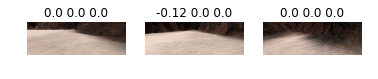

In [44]:
# Image generator
def gen_image(data):
    index = randint(0, len(data)-1)
    img = cv2.imread(data["Path"][index])
    steer = data['SteerAngle'][index]
    throttle = data['Throttle'][index]
    brake = data['Brake'][index]
    img = preprocessImg(img)
    return img, steer, throttle, brake

# Test - make sure it works
for i in range(1, 4):
    plt.subplot(1, 3, i)
    img, steer, throttle, brake= gen_image(robot_log)
    plt.imshow(img)
    plt.title(str(round(steer,2))+' '+str(round(throttle,2))+' '+str(round(brake,2)))
    plt.axis('off')
plt.show()

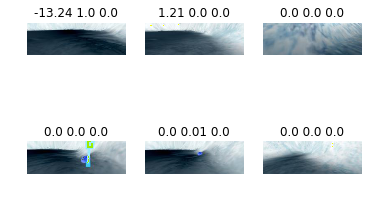

X_batch data type : float64
Y_batch data type : float64


In [46]:
# Batch generator
def gen_batch(data, batch_size):
    x_batch = np.zeros((batch_size, 66, 200, 3))
    y_batch = np.zeros((batch_size,3))  
    while 1:
        for i in range(batch_size):
            x, y1, y2, y3 = gen_image(data)
            x_batch[i], y_batch[i] = x, [y1,y2,y3]
        yield x_batch, y_batch

# Test - make sure it works
x_batch = np.zeros((10, 66, 200, 3))
y_batch = np.zeros((10,3))
x_batch, y_batch = next(gen_batch(robot_log, 10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(str(round(y_batch[i][0],2))+' '+str(round(y_batch[i][1],2))+' '+str(round(y_batch[i][2],2)))
    plt.axis('off')
plt.show()

print('X_batch data type :', x_batch.dtype)
print('Y_batch data type :', y_batch.dtype)

In [50]:
# Model training
# Network architecture adapts Nvidia's paper "End to End Learning for Self-Driving Cars"
model = Sequential()
    
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(66, 200, 3)))   
model.add(Conv2D(24, (5, 5), strides=(2, 2), padding="same", kernel_initializer ='he_normal'))
model.add(ELU())
model.add(Conv2D(36, (5, 5), strides=(2, 2), padding="same", kernel_initializer ='he_normal'))
model.add(ELU())
model.add(Conv2D(48, (5, 5), strides=(2, 2), padding="same", kernel_initializer ='he_normal')) 
model.add(ELU())
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer ='he_normal'))
model.add(ELU())
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer ='he_normal'))
model.add(ELU())                         
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(1164, kernel_initializer='he_normal'))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(100, kernel_initializer='he_normal'))
model.add(ELU())
model.add(Dense(50, kernel_initializer='he_normal'))
model.add(ELU())
model.add(Dense(10, kernel_initializer='he_normal'))
model.add(ELU())
model.add(Dense(3, kernel_initializer='he_normal'))

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer="adam", loss="mse")

In [48]:
# Split data into train and validation sets
train, validation = train_test_split(robot_log, test_size=0.10, random_state=1111)
train = train.reset_index()
validation = validation.reset_index()

# Sensibility check train vs validation data
print("Number of train examples =", len(train))
print("Number of validation examples =", len(validation))
print("Average train steering angles =", np.mean(train['SteerAngle']))
print("Average validation steering angles =", np.mean(validation['SteerAngle']))
print("Average train throttle =", np.mean(train['Throttle']))
print("Average validation throttle =", np.mean(validation['Throttle']))
print("Average train brake =", np.mean(train['Brake']))
print("Average validation brake =", np.mean(validation['Brake']))

Number of train examples = 22915
Number of validation examples = 2547
Average train steering angles = 0.255900108472
Average validation steering angles = 0.300693251007
Average train throttle = 0.099677613766
Average validation throttle = 0.0965139008206
Average train brake = 0.0463344991737
Average validation brake = 0.0397504740597


In [ ]:
# Train the model
model.fit_generator(
    gen_batch(train, 64),
    steps_per_epoch = 300,
    epochs = 10,
    validation_data = gen_batch(validation, 64),
    validation_steps = 30, verbose = 1
  )

model.save_weights('model.h5')
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

Epoch 1/10
 17/300 [>.............................] - ETA: 214s - loss: 14.3730